In [1]:
import matplotlib.pyplot as plt

from superfv import EulerSolver, plot_1d_slice, plot_timeseries
from superfv.initial_conditions import interacting_blast_wave_1d

In [2]:
N = 480
T = 0.038

configs = {
    "ref": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=1,
        MUSCL=True,
        MUSCL_limiter="moncen",
        SED=True,
    ),
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=1,
        MUSCL=True,
        MUSCL_limiter="moncen",
        SED=True,
    ),
    "MM3": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=3,
        MOOD=True,
        cascade="muscl",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-10,
        PAD={"rho": (0, None)},
        SED=True,
    ),
    "MM3-blended": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=3,
        MOOD=True,
        cascade="muscl",
        blend=True,
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-10,
        PAD={"rho": (0, None)},
        SED=True,
    ),
    "MM3-SED=False": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=3,
        MOOD=True,
        cascade="muscl",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-10,
        PAD={"rho": (0, None)},
        SED=False,
    ),
}

sims = {}
for name, config in configs.items():
    print(f"Running {name}...")
    sim = EulerSolver(
        ic=interacting_blast_wave_1d,
        bcx="reflective",
        nx=1000 if name == "ref" else N,
        **config,
    )

    try:
        if config.get("MUSCL", False):
            sim.musclhancock(T)
        elif "RK4" in name:
            sim.rk4(T)
        else:
            sim.run(T)
    except Exception as e:
        print(f"Failed: {e}")
        continue

    sims[name] = sim

Running ref...
Step #1997 @ t=3.80e-02 | dt=1.78e-05 | min(rho)=1.46e-01, min(P)=1.92e+01 | (done)                 
Running MUSCL-Hancock...
Step #952 @ t=3.80e-02 | dt=4.78e-05 | min(rho)=1.48e-01, min(P)=1.90e+01 | (done)                  
Running MM3...
Step #937 @ t=3.80e-02 | dt=3.96e-05 | min(rho)=1.49e-01, min(P)=1.90e+01 | (done)                  
Running MM3-blended...
Step #938 @ t=3.80e-02 | dt=3.55e-05 | min(rho)=1.49e-01, min(P)=1.90e+01 | (done)                  
Running MM3-SED=False...
Step #932 @ t=3.80e-02 | dt=2.63e-05 | min(rho)=1.50e-01, min(P)=1.90e+01 | (done)                  


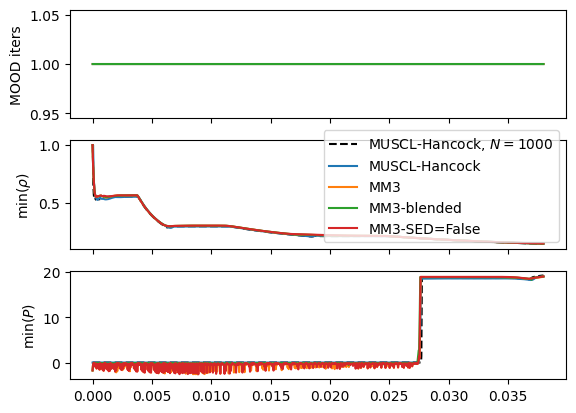

In [3]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].set_ylabel("MOOD iters")
axs[1].set_ylabel(r"$\min(\rho)$")
axs[2].set_ylabel(r"$\min(P)$")

for name, sim in sims.items():
    if name == "ref":
        plot_timeseries(
            sim,
            axs[1],
            "min_rho",
            label=r"MUSCL-Hancock, $N=1000$",
            color="k",
            linestyle="--",
        )
        plot_timeseries(
            sim,
            axs[2],
            "min_P",
            label=r"MUSCL-Hancock, $N=1000$",
            color="k",
            linestyle="--",
        )
        continue
    if name != "MUSCL-Hancock":
        plot_timeseries(sim, axs[0], "nfine_MOOD_iters", label=name)
    plot_timeseries(sim, axs[1], "min_rho", label=name)
    plot_timeseries(sim, axs[2], "min_P", label=name)

axs[1].legend()

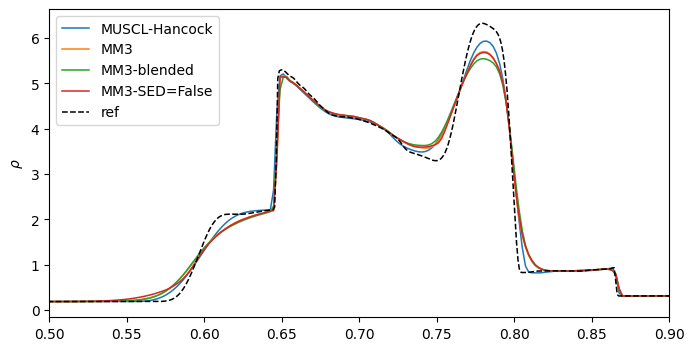

In [4]:
fig, ax = plt.subplots(1, figsize=(8, 4))

ax.set_ylabel(r"$\rho$")


style = dict(linewidth=1.1, markersize=3)

for name, sim in sims.items():
    if name == "ref":
        continue
    plot_1d_slice(sim, ax, "rho", label=name, **style)

if "ref" in sims:
    simMH = sims["ref"]
    plot_1d_slice(
        simMH,
        ax,
        "rho",
        label=r"ref",
        color="k",
        linestyle="--",
        **style,
    )

ax.set_xlim(0.5, 0.9)
ax.legend()